In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

In [2]:
# Load data
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train[:5000].astype('float32') / 255.
x_test = x_test[:1000].astype('float32') / 255.
y_train = y_train[:5000]
y_test = y_test[:1000]
print(np.unique(y_train))
print(np.unique(y_test))
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

Using TensorFlow backend.


[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
(5000, 32, 32, 3)
(1000, 32, 32, 3)
(5000, 1)
(1000, 1)


In [3]:
# Resize images to make it more challenging
x_train = np.array([resize(img, (64, 64)) for img in x_train]).astype('float32')
x_test = np.array([resize(img, (64, 64)) for img in x_test]).astype('float32')

C:\Users\pmeji\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\pmeji\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [4]:
# Function to add salt and pepper noise
def salt_and_pepper(img):
    n_rows, n_cols, n_chann = img.shape
    for row in range(n_rows):
        for col in range(n_cols):
            thresh = np.random.rand()
            if thresh > 0.9:
                img[row, col, :] = 1
            elif thresh < 0.1:
                img[row, col, :] = 0
    return img

In [5]:
# Create noisy copies
x_train_noise = np.array([salt_and_pepper(img.copy()) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy()) for img in x_test]).astype('float32')

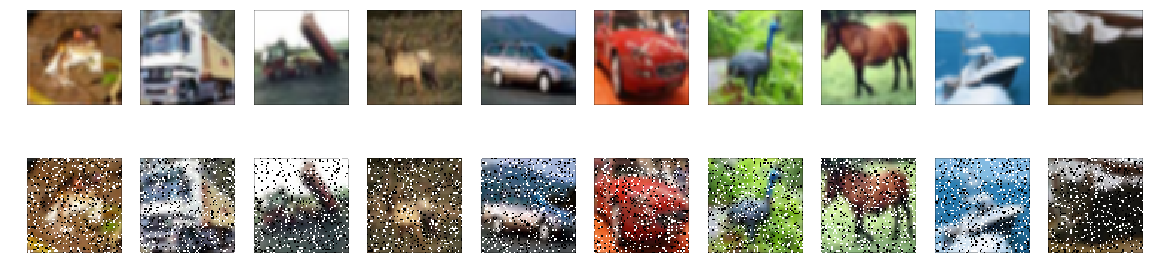

In [6]:
# plot a few examples
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_train[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_train_noise[it])
    plt.axis('off')
plt.show()

In [7]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, UpSampling2D
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape

### 0. Original

In [8]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 8)         584       
__________

In [9]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam')

In [10]:
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=10, verbose=1, validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 195s 49ms/step - loss: 0.0709 - val_loss: 0.0469
Epoch 2/10
4000/4000 [==============================] - 184s 46ms/step - loss: 0.0411 - val_loss: 0.0458
Epoch 3/10
4000/4000 [==============================] - 76s 19ms/step - loss: 0.0331 - val_loss: 0.0342
Epoch 4/10
4000/4000 [==============================] - 81s 20ms/step - loss: 0.0290 - val_loss: 0.0265
Epoch 5/10
4000/4000 [==============================] - 76s 19ms/step - loss: 0.0266 - val_loss: 0.0250
Epoch 6/10
4000/4000 [==============================] - 77s 19ms/step - loss: 0.0248 - val_loss: 0.0236
Epoch 7/10
4000/4000 [==============================] - 77s 19ms/step - loss: 0.0234 - val_loss: 0.0226
Epoch 8/10
4000/4000 [==============================] - 75s 19ms/step - loss: 0.0224 - val_loss: 0.0215
Epoch 9/10
4000/4000 [==============================] - 76s 19ms/step - loss: 0.0215 - val_loss: 0.0207
Epoch 10/10
40

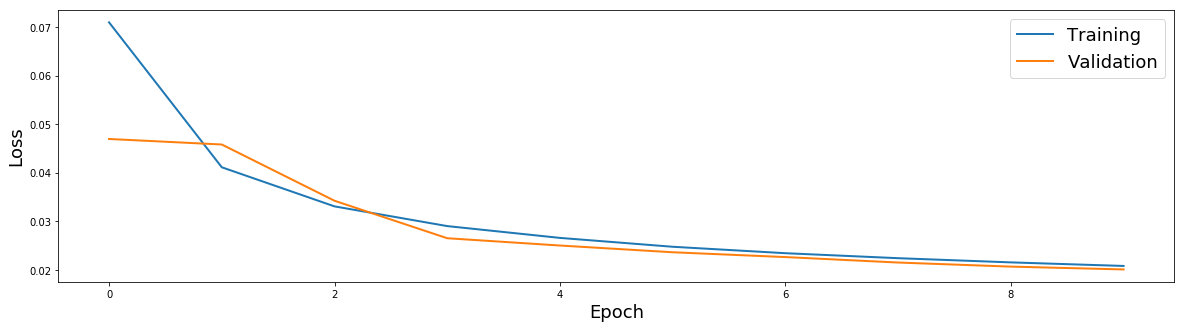

In [11]:
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

### 1. Mantienendo el número y orden inicial de layers, modifica el número de filtros o perceptrones

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        36928     
__________

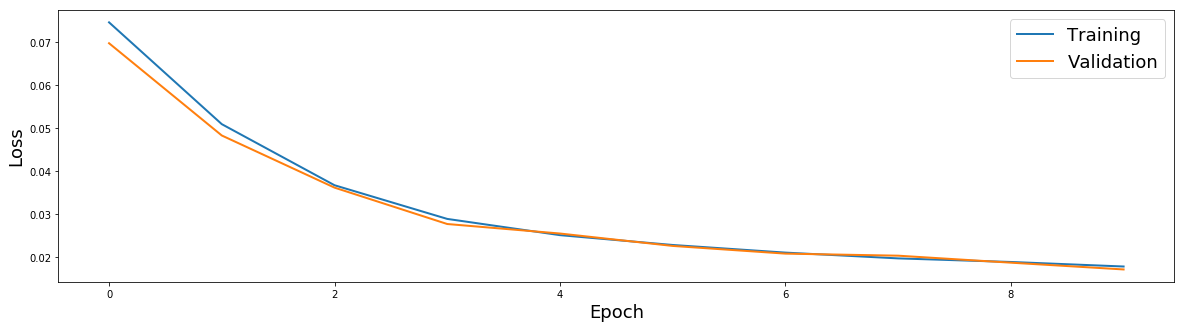

In [12]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=10, verbose=1, validation_split=0.2)
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

## 2. Explora diferentes tamaños de batch y número de épocas.


#### Exploración de tamaños de batch

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 550s 138ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 2/10
4000/4000 [==============================] - 546s 136ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 3/10
4000/4000 [==============================] - 547s 137ms/step - loss: 0.0077 - val_loss: 0.0098
Epoch 4/10
4000/4000 [==============================] - 544s 136ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 5/10
4000/4000 [==============================] - 547s 137ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 6/10
4000/4000 [==============================] - 549s 137ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 7/10
4000/4000 [==============================] - 545s 136ms/step - loss: 0.0078 - val_loss: 0.0086
Epoch 8/10
4000/4000 [==============================] - 545s 136ms/step - loss: 0.0078 - val_loss: 0.0073
Epoch 9/10
4000/4000 [==============================] - 544s 136ms/step - loss: 0.0075 - val_loss: 0.008

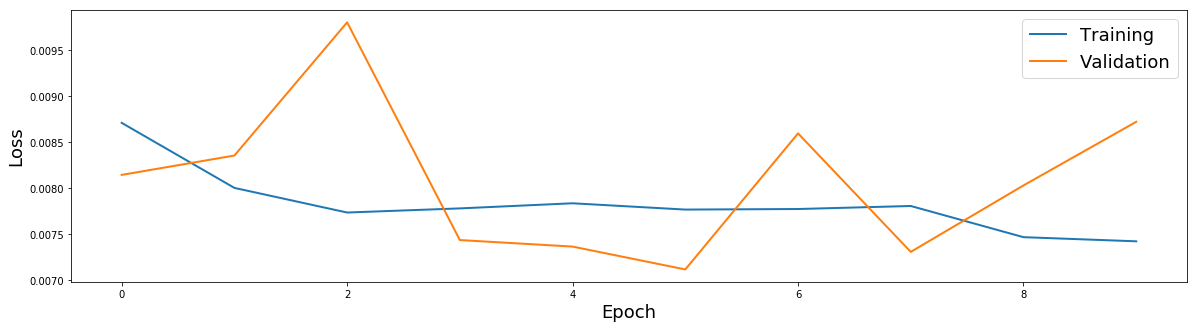

In [22]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 32
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=10, verbose=1, validation_split=0.2)
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es_bc = EarlyStopping(monitor='val_loss',
                      patience=4, 
                      verbose=1, 
                      mode='auto')
model.fit(x_train_noise, x_train,
          batch_size=myBatch, epochs=10, 
          verbose=1, validation_split=0.2,
          callbacks =[es_bc])

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 548s 137ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 2/10
4000/4000 [==============================] - 547s 137ms/step - loss: 0.0069 - val_loss: 0.0089
Epoch 3/10
4000/4000 [==============================] - 554s 139ms/step - loss: 0.0069 - val_loss: 0.0074
Epoch 4/10
4000/4000 [==============================] - 546s 136ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 5/10
4000/4000 [==============================] - 546s 137ms/step - loss: 0.0066 - val_loss: 0.0095
Epoch 6/10
4000/4000 [==============================] - 546s 136ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 7/10
4000/4000 [==============================] - 547s 137ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 8/10
4000/4000 [==============================] - 547s 137ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 9/10
4000/4000 [==============================] - 546s 136ms/step - loss: 0.0065 - val_loss: 0.006

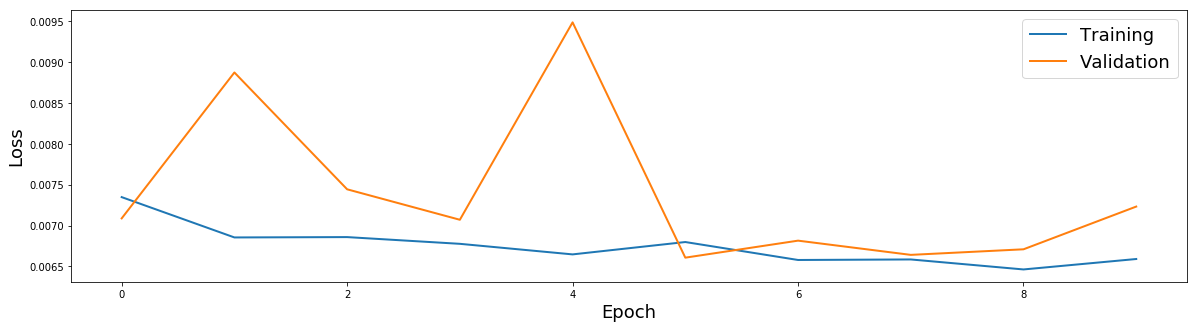

In [24]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 64
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=10, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 550s 137ms/step - loss: 0.0077 - val_loss: 0.0079
Epoch 2/10
4000/4000 [==============================] - 546s 137ms/step - loss: 0.0062 - val_loss: 0.0066
Epoch 3/10
4000/4000 [==============================] - 566s 141ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 4/10
4000/4000 [==============================] - 555s 139ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 5/10
4000/4000 [==============================] - 546s 137ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 6/10
4000/4000 [==============================] - 552s 138ms/step - loss: 0.0060 - val_loss: 0.0072
Epoch 7/10
4000/4000 [==============================] - 546s 136ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 8/10
4000/4000 [==============================] - 547s 137ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 9/10
4000/4000 [==============================] - 545s 136ms/step - loss: 0.0060 - val_loss: 0.006

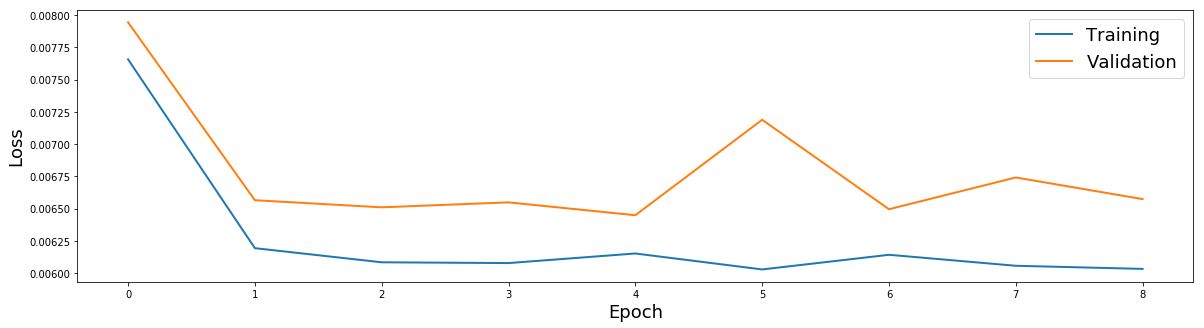

In [25]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 128
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=10, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 558s 140ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 2/10
4000/4000 [==============================] - 549s 137ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 3/10
4000/4000 [==============================] - 17749s 4s/step - loss: 0.0059 - val_loss: 0.0066
Epoch 4/10
4000/4000 [==============================] - 2207s 552ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 5/10
4000/4000 [==============================] - 554s 138ms/step - loss: 0.0058 - val_loss: 0.0067
Epoch 6/10
4000/4000 [==============================] - 548s 137ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 00006: early stopping


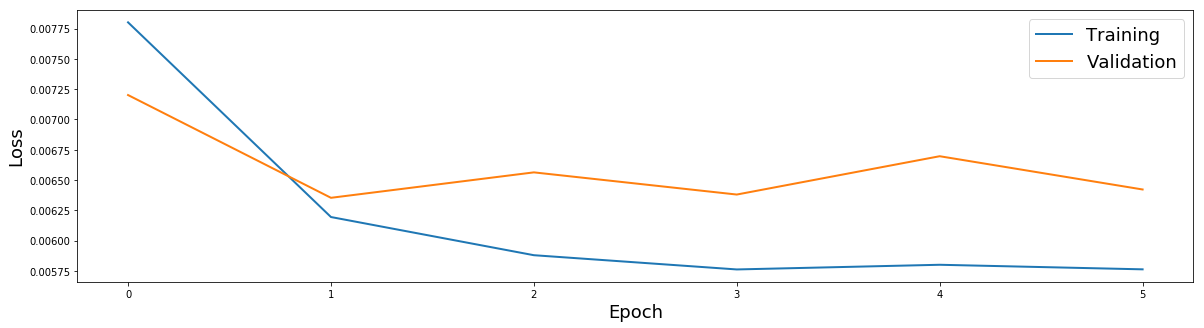

In [26]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 256
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=10, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

#### Exploración de número de épocas

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 549s 137ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 2/20
4000/4000 [==============================] - 540s 135ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 3/20
4000/4000 [==============================] - 541s 135ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 4/20
4000/4000 [==============================] - 539s 135ms/step - loss: 0.0069 - val_loss: 0.0075
Epoch 5/20
4000/4000 [==============================] - 541s 135ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 6/20
4000/4000 [==============================] - 540s 135ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 7/20
4000/4000 [==============================] - 540s 135ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 8/20
4000/4000 [==============================] - 539s 135ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 9/20
4000/4000 [==============================] - 541s 135ms/step - loss: 0.0068 - val_loss: 0.007

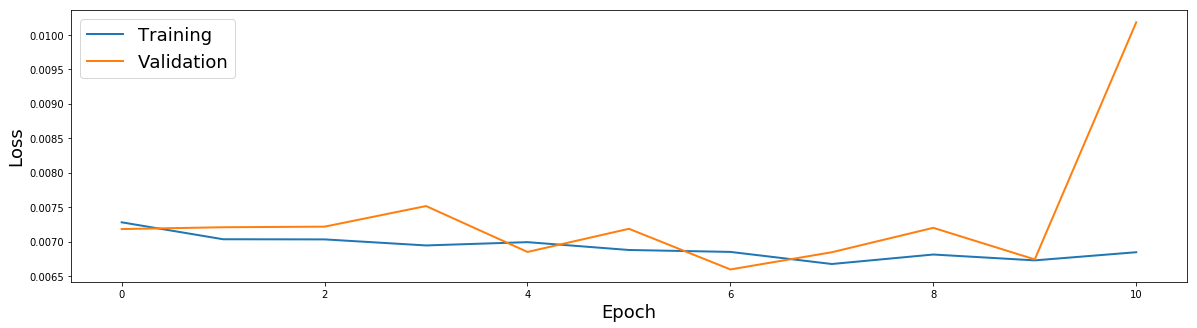

In [29]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 32
myEpoch = 20
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=myEpoch , verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5)) 
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [ ]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 256
myEpoch = 50
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=myEpoch , verbose=1, validation_split=0.2)
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [ ]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 32
myEpoch = 100
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=myEpoch , verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [ ]:
model = Model(inputs=i, outputs=o)
model.compile(loss='mse', optimizer='adam')

myBatch = 32
myEpoch = 200
# Training
model.fit(x_train_noise, x_train, batch_size=myBatch, epochs=myEpoch , verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

## 3. Modifica ahora el número, tipo y orden de layers.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
__________

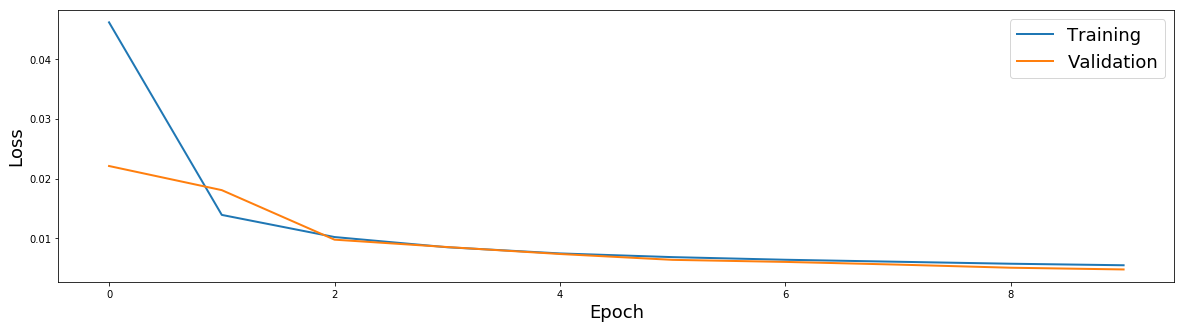

In [9]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=10, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

## 4. Evalua el desempeño usando sólo layers convolucionales.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        36928     
__________

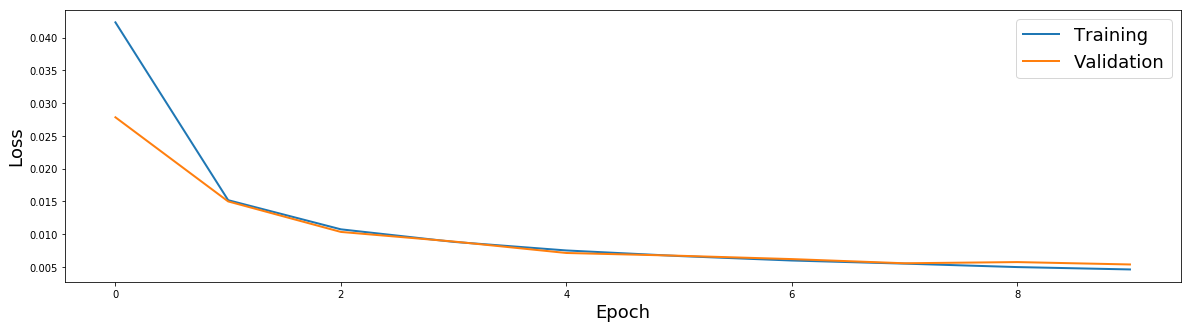

In [11]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=10, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

## 5. Identifica el modelo más robusto que hayas encontrado.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 16, 16, 64)        0         
__________

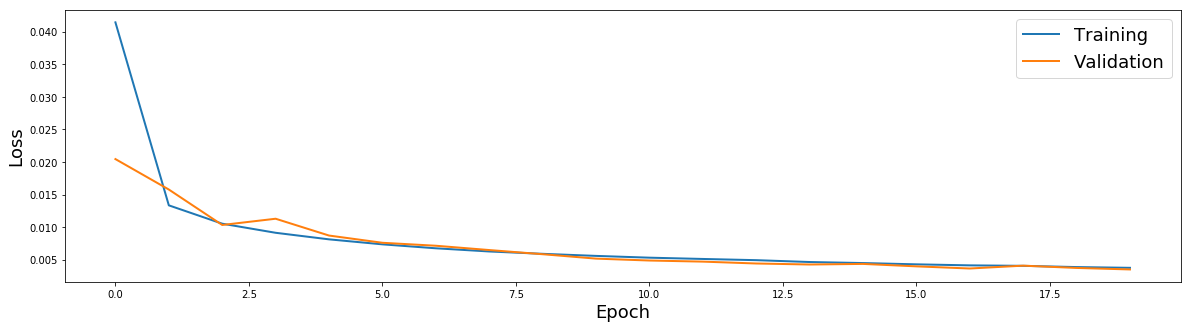

In [27]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(128, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)

# Optimization parameters
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=20, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

## 6. Intenta simplificarlo sin perder mucho en su desempeño.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 64, 64, 64)        0         
__________

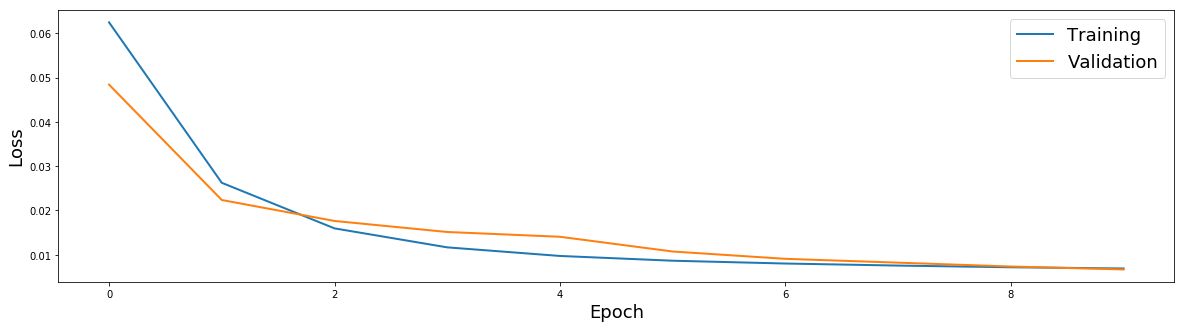

In [12]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = Dropout(0.2)(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=10, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 64, 64, 32)        0         
__________

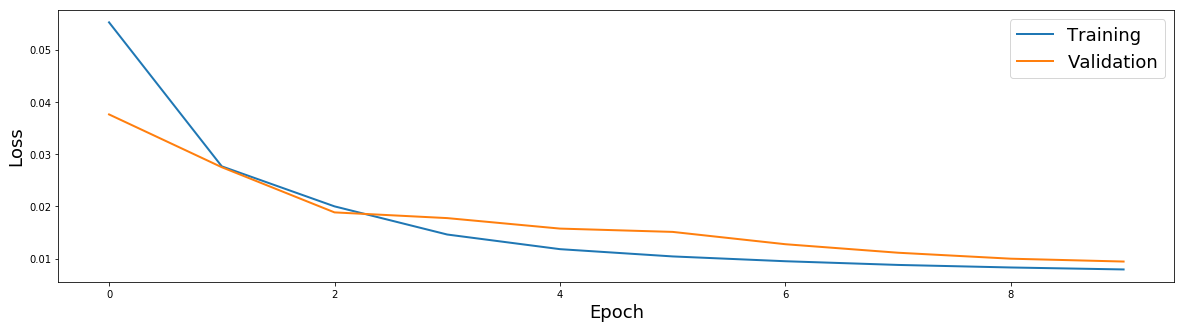

In [13]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = Dropout(0.2)(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=10, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 64, 64, 16)        0         
__________

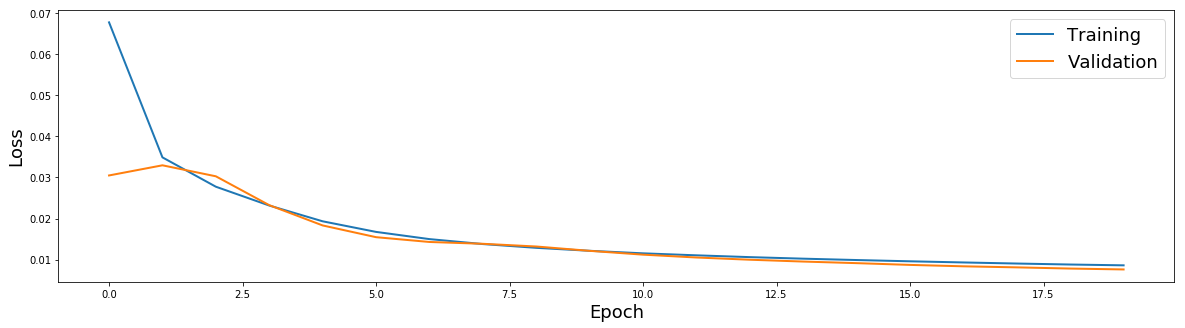

In [14]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = Dropout(0.2)(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=20, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 64, 64, 16)        0         
__________

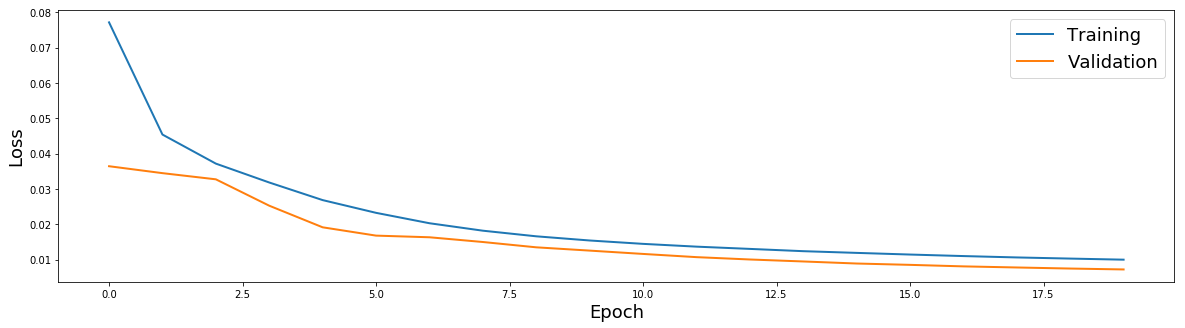

In [16]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = Dropout(0.2)(h)

h = UpSampling2D((2, 2))(h)
#h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=20, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 16)        64        
__________

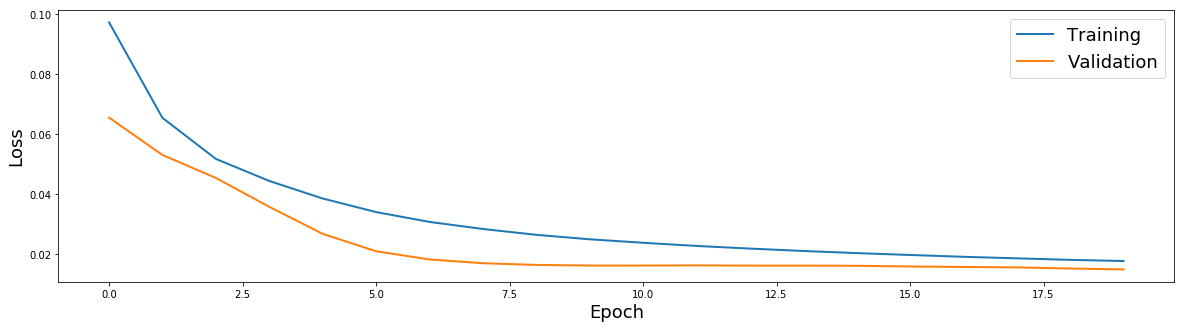

In [18]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = MaxPooling2D((2, 2))(h)
h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=20, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 64, 64, 16)        64        
__________

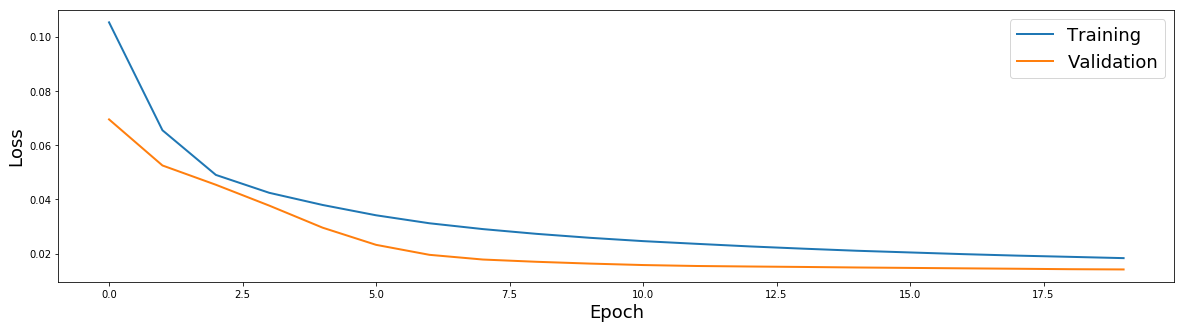

In [20]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = MaxPooling2D((2, 2))(h)
h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=20, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 3)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 32, 32, 3)         0         
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 64, 3)         84        
Total para

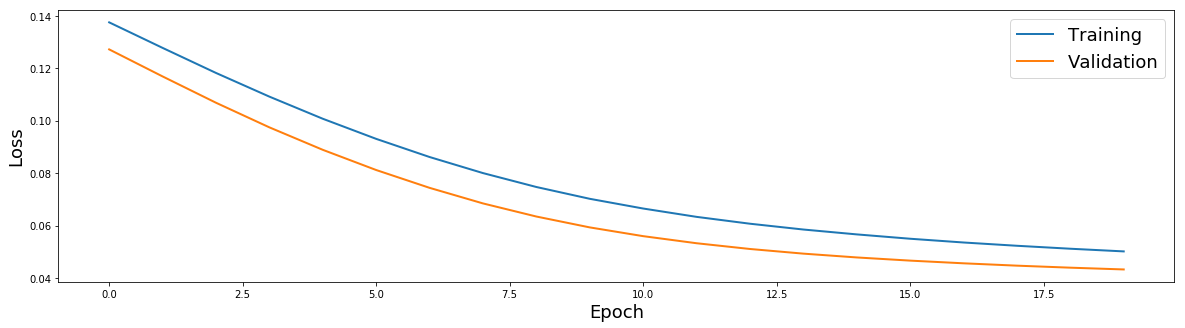

In [23]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

#h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

#h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = Dropout(0.2)(h)

h = UpSampling2D((2, 2))(h)
#h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=20, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

## Mejor modelo con más epocas

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
dropout_17 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 64, 64, 16)        0         
__________

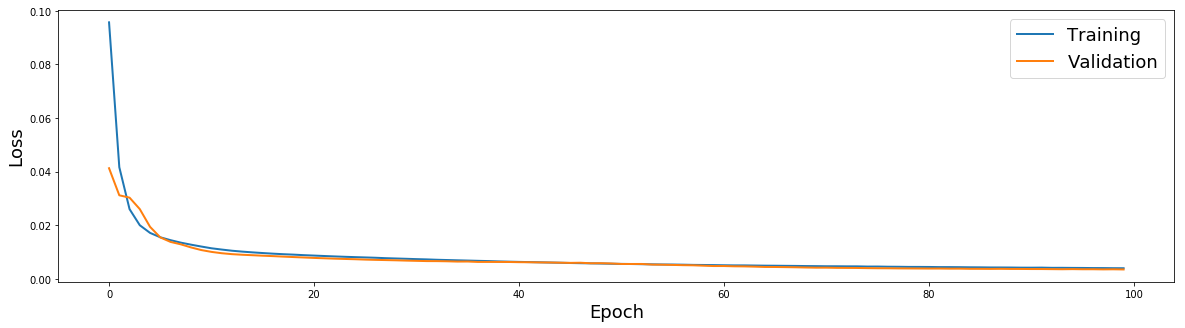

In [25]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = Dropout(0.2)(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=100, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
dropout_18 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
up_sampling2d_18 (UpSampling (None, 64, 64, 64)        0         
__________

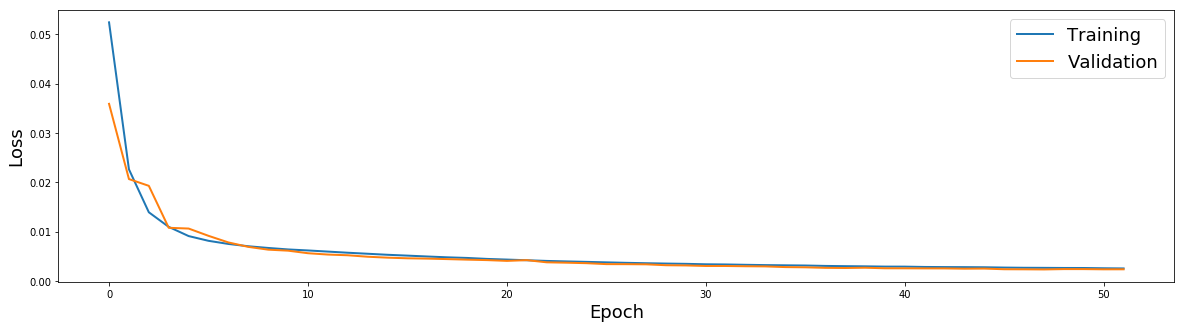

In [26]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(64, (3, 3), padding='same', activation='elu')(h)
h = Dropout(0.2)(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=100, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
up_sampling2d_21 (UpSampling (None, 64, 64, 16)        0         
__________

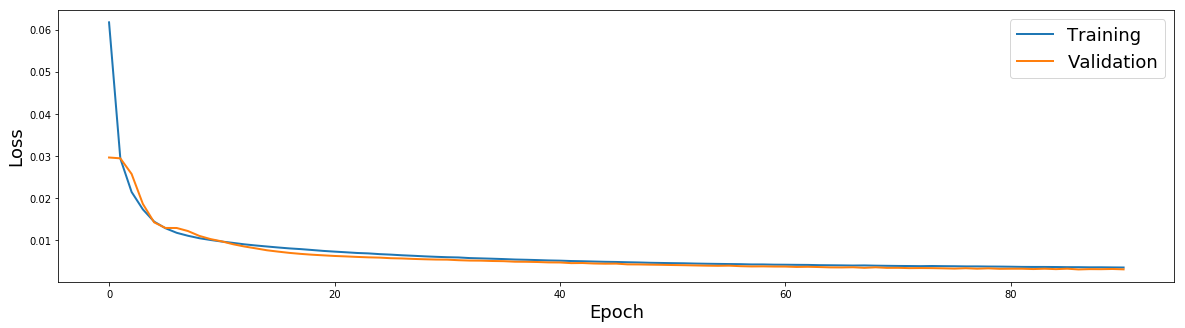

In [28]:
# Create NN
i = Input(x_train_noise.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = Dropout(0.2)(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

# Optimization parameters
model.compile(loss='mse', optimizer='adam')
# Training
model.fit(x_train_noise, x_train, batch_size=512, epochs=200, verbose=1, validation_split=0.2,callbacks =[es_bc])
# Plot loss
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

In [32]:
model.summary()
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
up_sampling2d_21 (UpSampling (None, 64, 64, 16)        0         
__________

In [33]:
# later...
from keras.models import model_from_json 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [34]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
up_sampling2d_21 (UpSampling (None, 64, 64, 16)        0         
__________

## 10. Presenta ejemplos de la reconstrucción o predicción de imágenes para los casos de denoising 

In [29]:
# Predict for test set
x_test_pred = model.predict(x_test_noise)

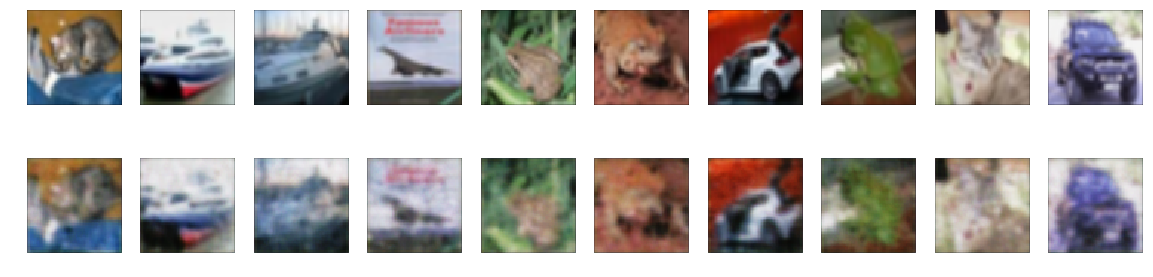

In [30]:
# plot a few examples
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_test[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_test_pred[it])
    plt.axis('off')
plt.show()

## Evaluar Modelo

In [26]:
# Function to add salt and pepper noise
def salt_and_pepper(img, amount):
    n_rows, n_cols, n_chann = img.shape
    for row in range(n_rows):
        for col in range(n_cols):
            thresh = np.random.rand()
            if thresh > (1-amount/2):
                img[row, col, :] = 1
            elif thresh < (amount/2):
                img[row, col, :] = 0
    return img


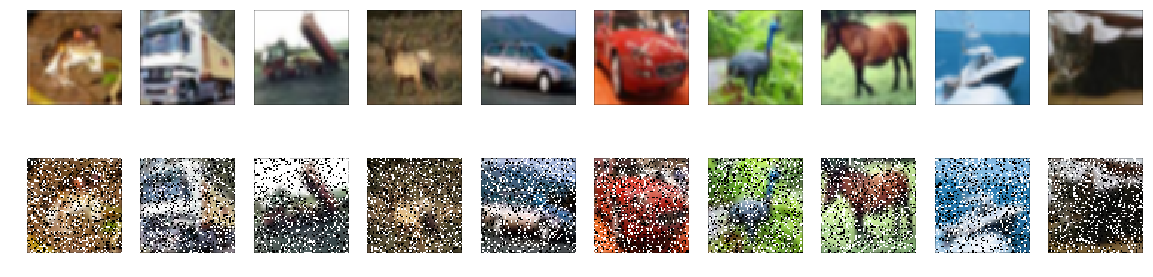

In [27]:
# Create noisy copies
x_train_noise = np.array([salt_and_pepper(img.copy(),.3) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy(),.3) for img in x_test]).astype('float32')

# plot a few examples
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_train[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_train_noise[it])
    plt.axis('off')
plt.show()

In [6]:
# later...
from keras.models import model_from_json 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [29]:
# Optimization parameters
from keras.callbacks import EarlyStopping, ModelCheckpoint
es_bc = EarlyStopping(monitor='val_loss',
                      patience=4, 
                      verbose=1, 
                      mode='auto')

loaded_model.compile(loss='mse', optimizer='adam')
# Training
loaded_model.fit(x_train_noise, x_train, batch_size=512, epochs=200, verbose=1, validation_split=0.2,callbacks =[es_bc])

Train on 4000 samples, validate on 1000 samples
Epoch 1/200
4000/4000 [==============================] - 74s 18ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 2/200
4000/4000 [==============================] - 69s 17ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 3/200
4000/4000 [==============================] - 69s 17ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 4/200
4000/4000 [==============================] - 69s 17ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 5/200
4000/4000 [==============================] - 77s 19ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 6/200
4000/4000 [==============================] - 76s 19ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 7/200
4000/4000 [==============================] - 73s 18ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 8/200
4000/4000 [==============================] - 74s 18ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 9/200
4000/4000 [==============================] - 71s 18ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 1

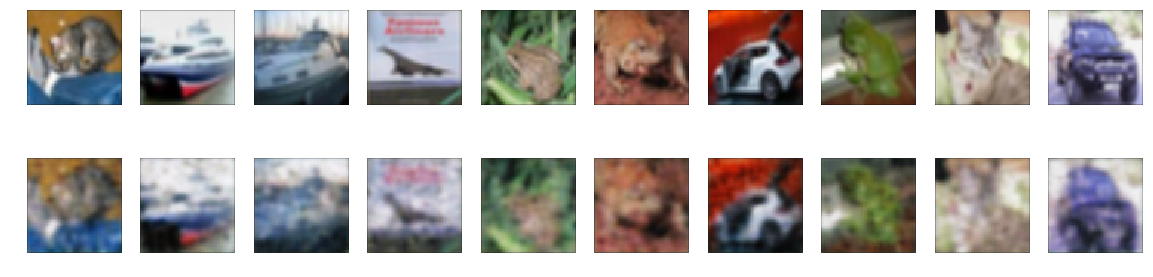

In [30]:
# Predict for test set
x_test_pred = loaded_model.predict(x_test_noise)
# plot a few examples
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_test[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_test_pred[it])
    plt.axis('off')
plt.show()

In [31]:
# Create noisy copies
x_train_noise = np.array([salt_and_pepper(img.copy(),.4) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy(),.4) for img in x_test]).astype('float32')

loaded_model.compile(loss='mse', optimizer='adam')
loaded_model.fit(x_train_noise, x_train, batch_size=512, epochs=200, verbose=1, validation_split=0.2,callbacks =[es_bc])

Train on 4000 samples, validate on 1000 samples
Epoch 1/200
4000/4000 [==============================] - 74s 18ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 2/200
4000/4000 [==============================] - 75s 19ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 3/200
4000/4000 [==============================] - 72s 18ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 4/200
4000/4000 [==============================] - 72s 18ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 5/200
4000/4000 [==============================] - 72s 18ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 6/200
4000/4000 [==============================] - 73s 18ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 7/200
4000/4000 [==============================] - 72s 18ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 8/200
4000/4000 [==============================] - 76s 19ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 9/200
4000/4000 [==============================] - 87s 22ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 1

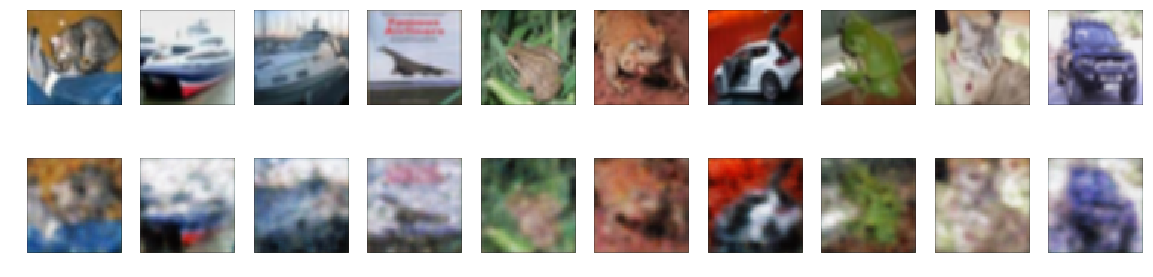

In [32]:
# Predict for test set
x_test_pred = loaded_model.predict(x_test_noise)
# plot a few examples
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_test[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_test_pred[it])
    plt.axis('off')
plt.show()

In [33]:
# Create noisy copies
x_train_noise = np.array([salt_and_pepper(img.copy(),.5) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy(),.5) for img in x_test]).astype('float32')

loaded_model.compile(loss='mse', optimizer='adam')
loaded_model.fit(x_train_noise, x_train, batch_size=512, epochs=200, verbose=1, validation_split=0.2,callbacks =[es_bc])

Train on 4000 samples, validate on 1000 samples
Epoch 1/200
4000/4000 [==============================] - 65s 16ms/step - loss: 0.0077 - val_loss: 0.0073
Epoch 2/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 3/200
4000/4000 [==============================] - 65s 16ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 4/200
4000/4000 [==============================] - 65s 16ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 5/200
4000/4000 [==============================] - 62s 16ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 6/200
4000/4000 [==============================] - 62s 15ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 00006: early stopping


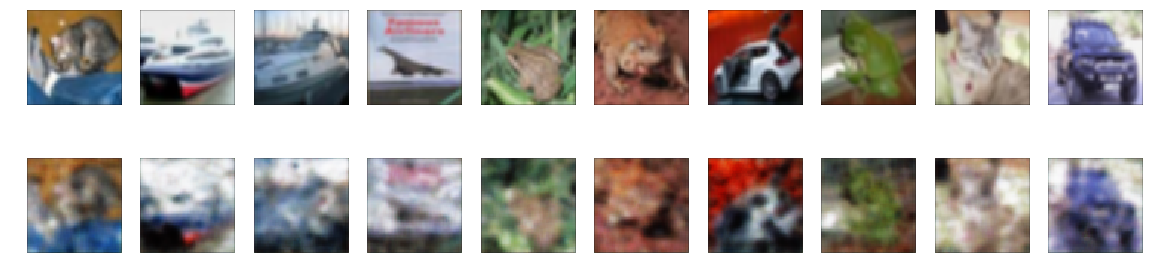

In [34]:
# Predict for test set
x_test_pred = loaded_model.predict(x_test_noise)
# plot a few examples
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_test[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_test_pred[it])
    plt.axis('off')
plt.show()

In [35]:
# Create noisy copies
x_train_noise = np.array([salt_and_pepper(img.copy(),.6) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy(),.6) for img in x_test]).astype('float32')

loaded_model.compile(loss='mse', optimizer='adam')
loaded_model.fit(x_train_noise, x_train, batch_size=512, epochs=200, verbose=1, validation_split=0.2,callbacks =[es_bc])

Train on 4000 samples, validate on 1000 samples
Epoch 1/200
4000/4000 [==============================] - 62s 16ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 2/200
4000/4000 [==============================] - 61s 15ms/step - loss: 0.0109 - val_loss: 0.0119
Epoch 3/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0109 - val_loss: 0.0119
Epoch 4/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 5/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0107 - val_loss: 0.0107
Epoch 6/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0106 - val_loss: 0.0107
Epoch 7/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0106 - val_loss: 0.0108
Epoch 8/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0106 - val_loss: 0.0110
Epoch 9/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0105 - val_loss: 0.0107
Epoch 0

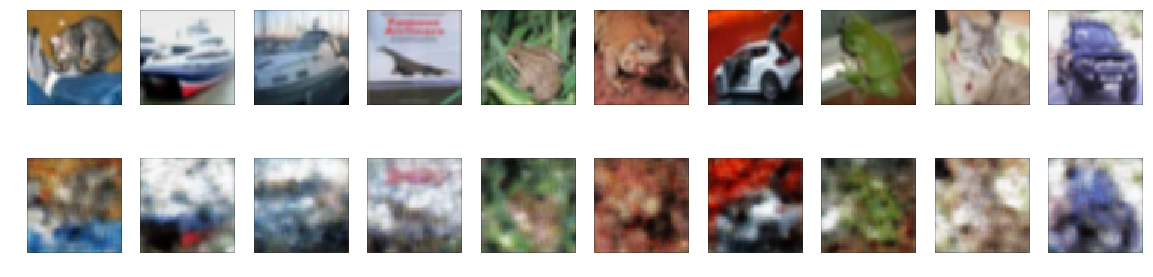

In [37]:
# Predict for test set
x_test_pred = loaded_model.predict(x_test_noise)
# plot a few examples
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_test[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_test_pred[it])
    plt.axis('off')
plt.show()

In [38]:
# Create noisy copies
x_train_noise = np.array([salt_and_pepper(img.copy(),.8) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy(),.8) for img in x_test]).astype('float32')

loaded_model.compile(loss='mse', optimizer='adam')
loaded_model.fit(x_train_noise, x_train, batch_size=512, epochs=200, verbose=1, validation_split=0.2,callbacks =[es_bc])

Train on 4000 samples, validate on 1000 samples
Epoch 1/200
4000/4000 [==============================] - 68s 17ms/step - loss: 0.0295 - val_loss: 0.0340
Epoch 2/200
4000/4000 [==============================] - 66s 17ms/step - loss: 0.0287 - val_loss: 0.0309
Epoch 3/200
4000/4000 [==============================] - 65s 16ms/step - loss: 0.0283 - val_loss: 0.0304
Epoch 4/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0281 - val_loss: 0.0296
Epoch 5/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0279 - val_loss: 0.0298
Epoch 6/200
4000/4000 [==============================] - 65s 16ms/step - loss: 0.0278 - val_loss: 0.0289
Epoch 7/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0277 - val_loss: 0.0288
Epoch 8/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0276 - val_loss: 0.0286
Epoch 9/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0275 - val_loss: 0.0290
Epoch 1

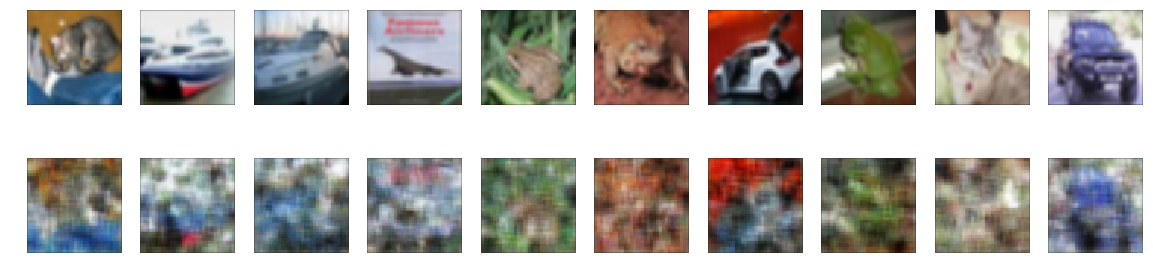

In [39]:
# Predict for test set
x_test_pred = loaded_model.predict(x_test_noise)
# plot a few examples
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_test[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_test_pred[it])
    plt.axis('off')
plt.show()

In [40]:
# Create noisy copies
x_train_noise = np.array([salt_and_pepper(img.copy(),.9) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy(),.9) for img in x_test]).astype('float32')

loaded_model.compile(loss='mse', optimizer='adam')
loaded_model.fit(x_train_noise, x_train, batch_size=512, epochs=200, verbose=1, validation_split=0.2,callbacks =[es_bc])

Train on 4000 samples, validate on 1000 samples
Epoch 1/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0454 - val_loss: 0.0482
Epoch 2/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0444 - val_loss: 0.0466
Epoch 3/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0440 - val_loss: 0.0457
Epoch 4/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0438 - val_loss: 0.0458
Epoch 5/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0437 - val_loss: 0.0456
Epoch 6/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0436 - val_loss: 0.0453
Epoch 7/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0436 - val_loss: 0.0458
Epoch 8/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0435 - val_loss: 0.0449
Epoch 9/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0435 - val_loss: 0.0453
Epoch 1

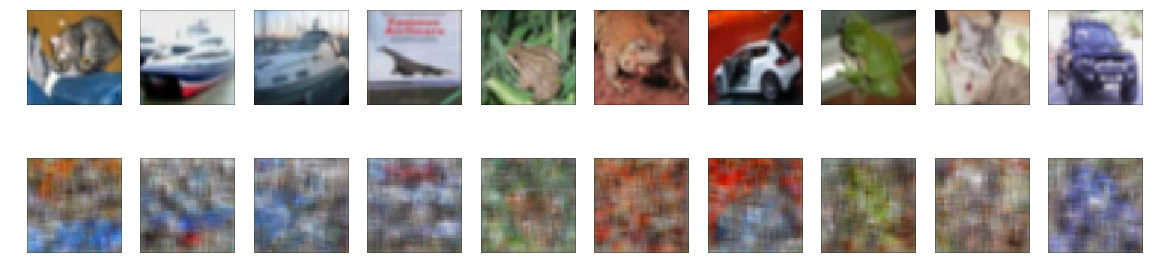

In [41]:
# Predict for test set
x_test_pred = loaded_model.predict(x_test_noise)
# plot a few examples
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_test[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_test_pred[it])
    plt.axis('off')
plt.show()

In [42]:
# Create noisy copies
x_train_noise = np.array([salt_and_pepper(img.copy(),1) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy(),1) for img in x_test]).astype('float32')

loaded_model.compile(loss='mse', optimizer='adam')
loaded_model.fit(x_train_noise, x_train, batch_size=512, epochs=200, verbose=1, validation_split=0.2,callbacks =[es_bc])

Train on 4000 samples, validate on 1000 samples
Epoch 1/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0625 - val_loss: 0.0611
Epoch 2/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0599 - val_loss: 0.0648
Epoch 3/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0591 - val_loss: 0.0625
Epoch 4/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0586 - val_loss: 0.0599
Epoch 5/200
4000/4000 [==============================] - 67s 17ms/step - loss: 0.0584 - val_loss: 0.0596
Epoch 6/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0582 - val_loss: 0.0596
Epoch 7/200
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0582 - val_loss: 0.0594
Epoch 8/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0581 - val_loss: 0.0594
Epoch 9/200
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0581 - val_loss: 0.0594
Epoch 1

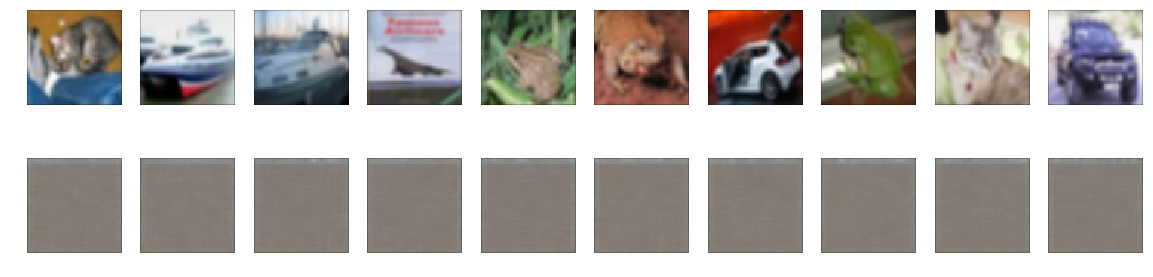

In [43]:
# Predict for test set
x_test_pred = loaded_model.predict(x_test_noise)
# plot a few examples
plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_test[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_test_pred[it])
    plt.axis('off')
plt.show()

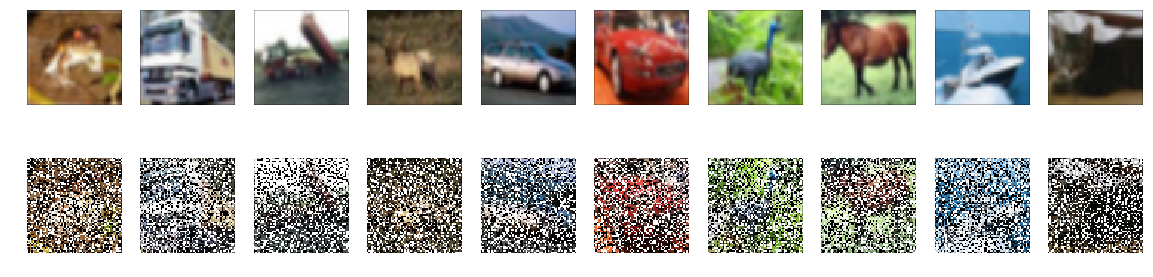

In [48]:
# plot a few examples
# Create noisy copies
x_train_noise = np.array([salt_and_pepper(img.copy(),0.6) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy(),0.6) for img in x_test]).astype('float32')

plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_train[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_train_noise[it])
    plt.axis('off')
plt.show()

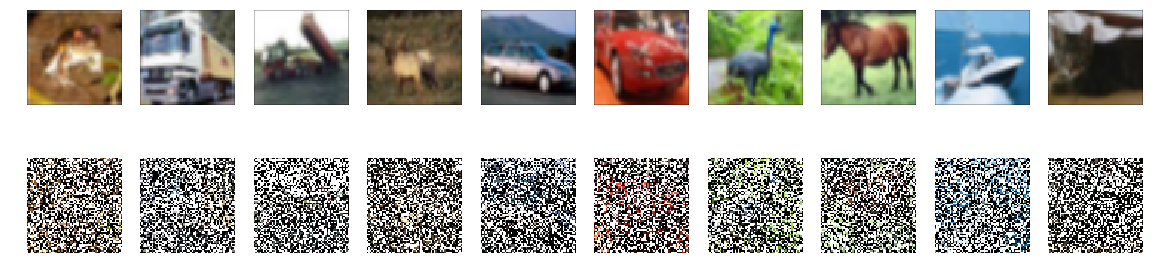

In [49]:
# plot a few examples
# Create noisy copies
x_train_noise = np.array([salt_and_pepper(img.copy(),0.8) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy(),0.8) for img in x_test]).astype('float32')

plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_train[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_train_noise[it])
    plt.axis('off')
plt.show()

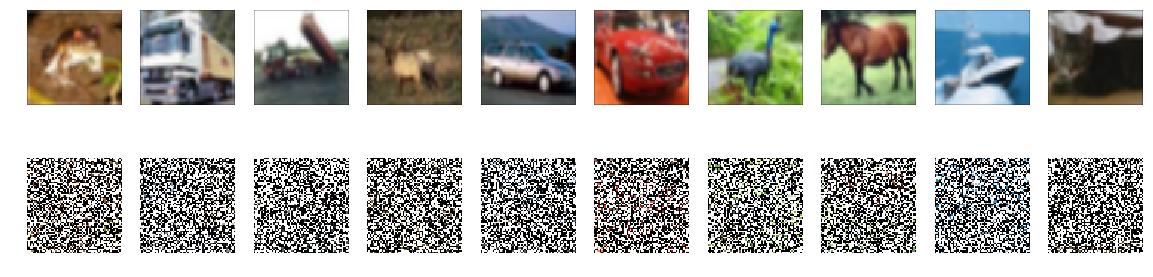

In [50]:
# plot a few examples
# Create noisy copies
x_train_noise = np.array([salt_and_pepper(img.copy(),0.9) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy(),0.9) for img in x_test]).astype('float32')

plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_train[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_train_noise[it])
    plt.axis('off')
plt.show()

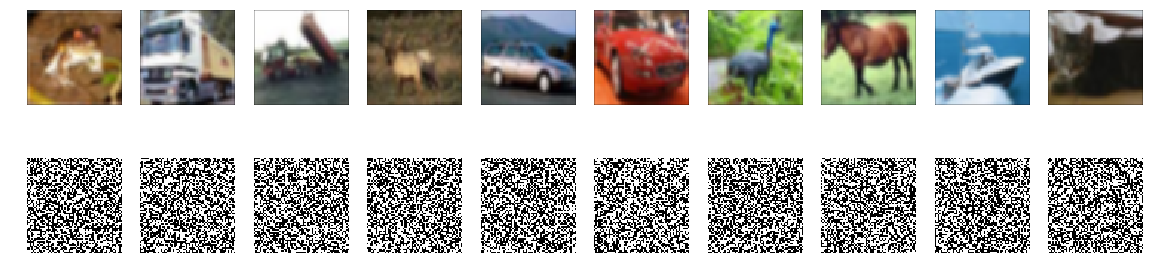

In [51]:
# plot a few examples
# Create noisy copies
x_train_noise = np.array([salt_and_pepper(img.copy(),1) for img in x_train]).astype('float32')
x_test_noise = np.array([salt_and_pepper(img.copy(),1) for img in x_test]).astype('float32')

plt.figure(figsize=(20, 5))
for it in range(10):
    plt.subplot(2, 10, it+1)
    plt.imshow(x_train[it])
    plt.axis('off')
    plt.subplot(2, 10, it+11)
    plt.imshow(x_train_noise[it])
    plt.axis('off')
plt.show()